#**Importing Libraries**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from scipy.stats import randint
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.optimizers import Adam

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [5]:
'''
#bimz-add
from google.colab import drive
drive.mount('/content/drive')
dataset_path = '/content/drive/MyDrive'
import pandas as pd

data = pd.read_csv('/content/blogtext.csv',nrows=20000)

df= data
print(df.shape)

# Loading CSV file
file_path = '/content/blogtext.csv'
df = pd.read_csv(file_path)
'''

ParserError: ignored

In [6]:
# loading data
df = pd.read_csv("blogtext.csv", nrows=20000)
print(df.shape)

(20000, 7)


# **EDA**

In [7]:
df.head()

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...


In [8]:
df.isnull().sum()

id        0
gender    0
age       0
topic     0
sign      0
date      0
text      0
dtype: int64

In [9]:
df.describe()

,id,age
count,2.000000e+04,20000.000000
mean,2.185862e+06,26.377900
std,1.295951e+06,8.202552
min,2.319100e+04,13.000000
25%,8.831780e+05,17.000000
50%,2.061087e+06,26.000000
75%,3.456634e+06,35.000000
max,4.337133e+06,48.000000


In [10]:
df["topic"].value_counts()

indUnk                     7789
Technology                 2989
Student                    2637
Fashion                    1622
Internet                    778
Education                   759
Communications-Media        414
Arts                        358
Engineering                 357
Marketing                   207
Non-Profit                  204
Government                  187
BusinessServices            184
Religion                    182
Consulting                  166
Sports-Recreation           120
Automotive                  111
Manufacturing                93
LawEnforcement-Security      90
Banking                      89
Science                      87
InvestmentBanking            71
Publishing                   70
Museums-Libraries            67
Law                          47
Agriculture                  46
Transportation               46
Architecture                 45
Advertising                  42
Biotech                      36
Accounting                   35
Construc

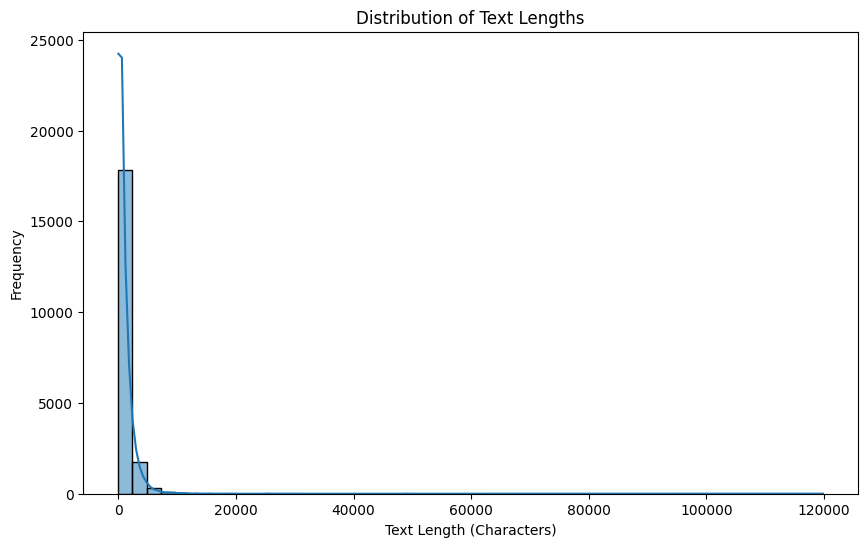

In [11]:
# Calculate the length of each text in terms of characters
df['text_length'] = df['text'].apply(len)

# Plot a histogram of text lengths
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='text_length', bins=50, kde=True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length (Characters)')
plt.ylabel('Frequency')
plt.show()



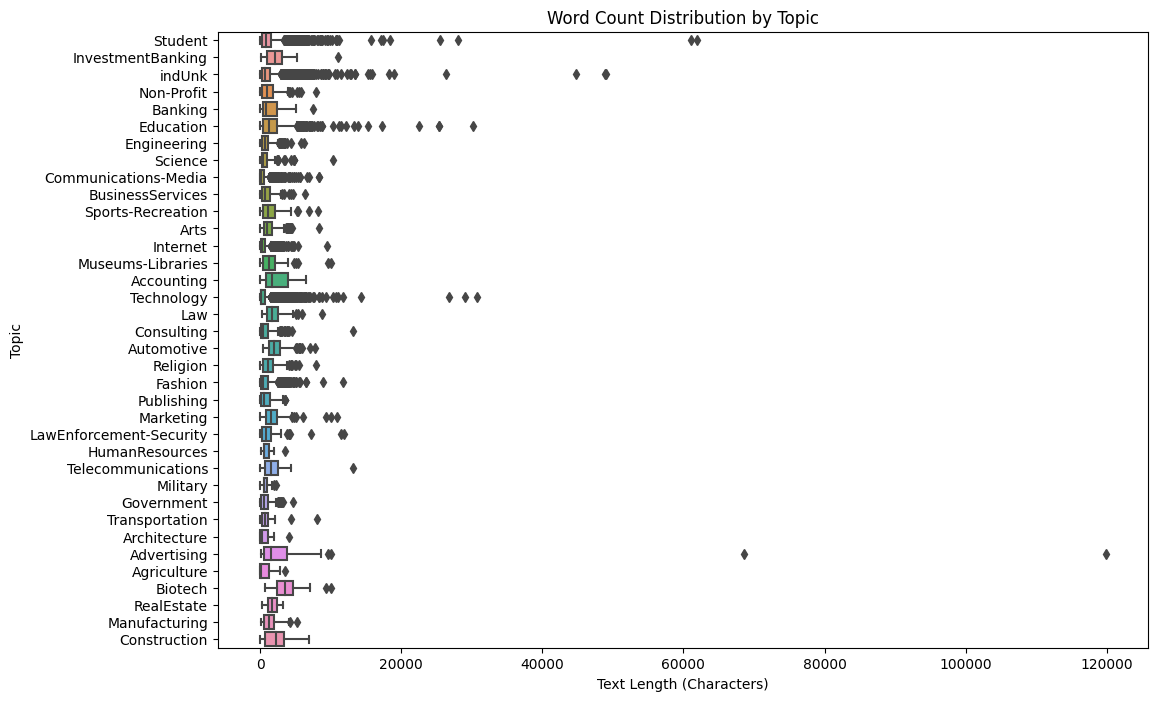

In [12]:
# Word Count Distribution by Topic:

plt.figure(figsize=(12, 8))
sns.boxplot(data=df, y='topic', x='text_length')
plt.title('Word Count Distribution by Topic')
plt.ylabel('Topic')
plt.xlabel('Text Length (Characters)')
plt.show()

# **Pre-processing**

In [13]:
# Lowercasing
df['processed_text'] = df['text'].apply(lambda x: x.lower())
df['processed_text'].head()

0               info has been found (+/- 100 pages,...
1               these are the team members:   drewe...
2               in het kader van kernfusie op aarde...
3                     testing!!!  testing!!!          
4                 thanks to yahoo!'s toolbar i can ...
Name: processed_text, dtype: object

In [14]:
# Remove special characters and numbers
df['processed_text'] = df['processed_text'].apply(lambda x: re.sub(r"[^a-zA-Z]", " ", x))
df['processed_text'].head()

0               info has been found          pages ...
1               these are the team members    drewe...
2               in het kader van kernfusie op aarde...
3                     testing     testing             
4                 thanks to yahoo  s toolbar i can ...
Name: processed_text, dtype: object

In [15]:
# Tokenization and remove stop words
stop_words = set(stopwords.words("english"))
df['processed_text'] = df['processed_text'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in stop_words]))
df['processed_text'].head()

0    info found pages mb pdf files wait untill team...
1    team members drewes van der laag urllink mail ...
2    het kader van kernfusie op aarde maak je eigen...
3                                      testing testing
4    thanks yahoo toolbar capture urls popups means...
Name: processed_text, dtype: object

In [16]:
# Lemmatization
lemmatizer = WordNetLemmatizer()
df['processed_text'] = df['processed_text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(x)]))
df.head()

,id,gender,age,topic,sign,date,text,text_length,processed_text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,...",157,info found page mb pdf file wait untill team l...
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...,181,team member drewes van der laag urllink mail r...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...,25467,het kader van kernfusie op aarde maak je eigen...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!,43,testing testing
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...,402,thanks yahoo toolbar capture url popups mean s...


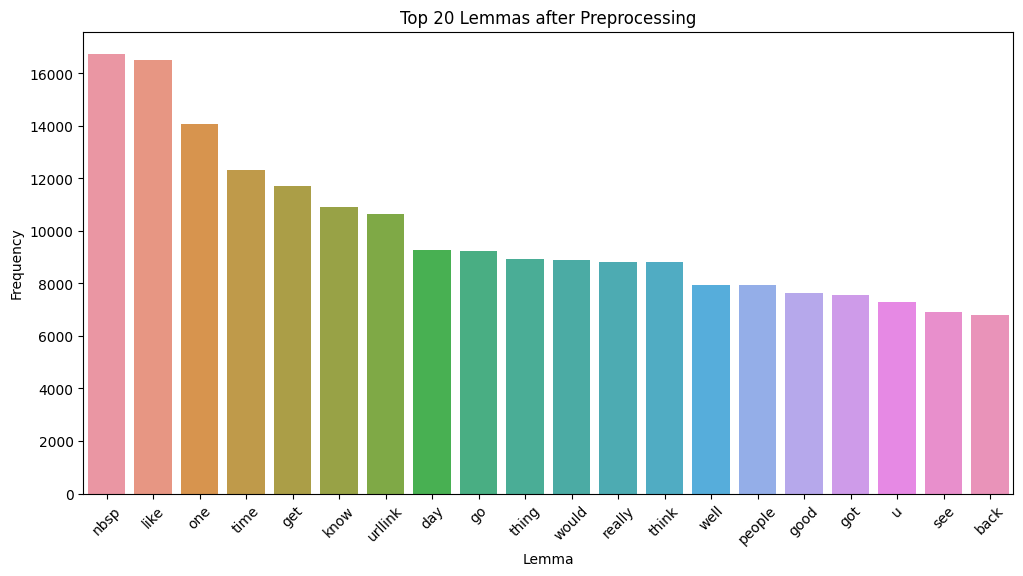

In [17]:
# bimz-ad Plot the top N lemmas
from collections import Counter
N = 20  # Change this to the desired number of top lemmas
all_lemmas = ' '.join(df['processed_text']).split()
lemma_counts = Counter(all_lemmas)
top_lemmas = lemma_counts.most_common(N)
top_lemmas, freq = zip(*top_lemmas)
plt.figure(figsize=(12, 6))
sns.barplot(x=list(top_lemmas), y=list(freq))
plt.title(f'Top {N} Lemmas after Preprocessing')
plt.xlabel('Lemma')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

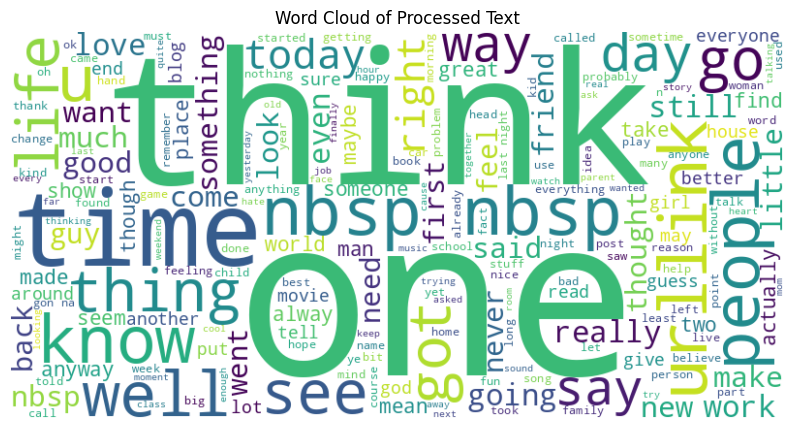

In [18]:
# bimz-add  Generate the word cloud
# Add the import statement for WordCloud
from wordcloud import WordCloud

all_text = ' '.join(df['processed_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Processed Text')
plt.axis('off')
plt.show()

In [19]:
# Create a new dataframe with two columns
df2 = df[["sign", "processed_text"]]
df2.head()

,sign,processed_text
0,Leo,info found page mb pdf file wait untill team l...
1,Leo,team member drewes van der laag urllink mail r...
2,Leo,het kader van kernfusie op aarde maak je eigen...
3,Leo,testing testing
4,Aquarius,thanks yahoo toolbar capture url popups mean s...


In [20]:
print(df2['sign'].unique())

['Leo' 'Aquarius' 'Aries' 'Capricorn' 'Gemini' 'Cancer' 'Sagittarius'
 'Scorpio' 'Libra' 'Virgo' 'Taurus' 'Pisces']


In [21]:
from sklearn.preprocessing import LabelEncoder
# Create a LabelEncoder object
label_encoder = LabelEncoder()
# Fit the LabelEncoder on the 'zodiac_sign' column to learn the mapping
label_encoder.fit(df2['sign'])
# Transform the zodiac sign labels to encoded numerical labels
df2['sign_id'] = label_encoder.transform(df2['sign'])

df2.head()

<ipython-input-21-61342d0deba8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['sign_id'] = label_encoder.transform(df2['sign'])


,sign,processed_text,sign_id
0,Leo,info found page mb pdf file wait untill team l...,5
1,Leo,team member drewes van der laag urllink mail r...,5
2,Leo,het kader van kernfusie op aarde maak je eigen...,5
3,Leo,testing testing,5
4,Aquarius,thanks yahoo toolbar capture url popups mean s...,0


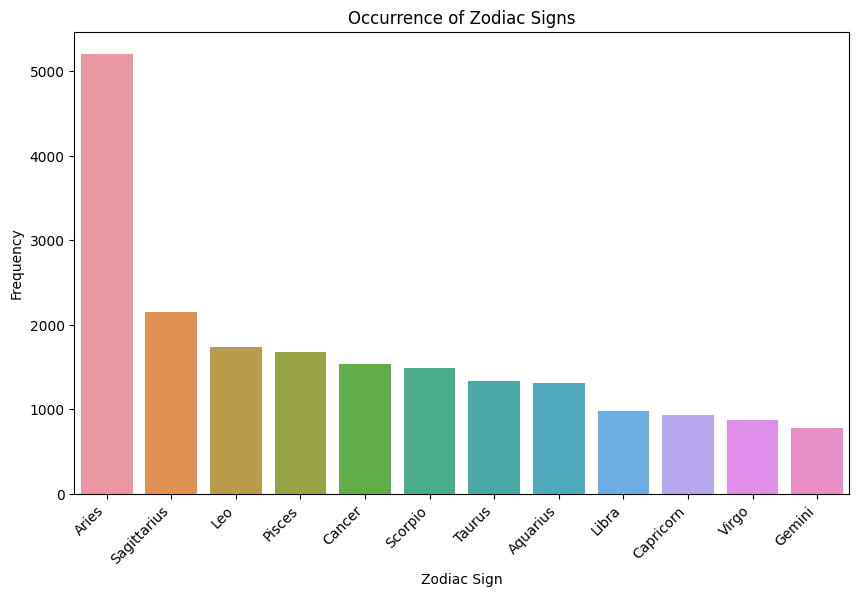

In [22]:
# Plot the occurrence of each zodiac sign using seaborn
plt.figure(figsize=(10, 6))
sns.countplot(data=df2, x='sign', order=df2['sign'].value_counts().index)
plt.xlabel('Zodiac Sign')
plt.ylabel('Frequency')
plt.title('Occurrence of Zodiac Signs')
plt.xticks(rotation=45, ha='right')
plt.show()

In [23]:
# Create a TF-IDF Vectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, ngram_range=(1,2), stop_words="english")
features = tfidf.fit_transform(df.text).toarray()
labels = df2['sign_id']
features.shape

(20000, 49165)

In [24]:
# Define the number of most correlated terms to display
N = 2
sign_id_df = df2[["sign", "sign_id"]].drop_duplicates()
sign_to_id = dict(sign_id_df.values)

In [25]:
sign_id_df.head(12)

,sign,sign_id
0,Leo,5
4,Aquarius,0
74,Aries,1
95,Capricorn,3
97,Gemini,4
133,Cancer,2
211,Sagittarius,8
283,Scorpio,9
573,Libra,6
989,Virgo,11


In [26]:
from sklearn.feature_selection import chi2

# Iterate through each zodiac sign and its corresponding ID
for sign, sign_id in sorted(sign_to_id.items()):
    # Calculate chi-squared test between features and the current sign's labels
    features_chi2 = chi2(features, labels == sign_id)

    # Sort feature indices based on chi-squared test statistics
    indices = np.argsort(features_chi2[0])

    # Get the feature names (terms) in sorted order based on chi-squared test
    feature_names = np.array(tfidf.get_feature_names_out())[indices]

    # Filter out unigrams and bigrams from the sorted feature names
    unigrams = [v for v in feature_names if len(v.split(" ")) == 1]
    bigrams = [v for v in feature_names if len(v.split(" ")) == 2]

    # Print the most correlated unigrams and bigrams for the current zodiac sign
    print("n--> %s:" %(sign))
    print("  * Most Correlated Unigrams are: %s" %(", ".join(unigrams[-N:])))
    print("  * Most Correlated Bigrams are: %s" %(", ".join(bigrams[-N:])))

n--> Aquarius:
  * Most Correlated Unigrams are: tori, ked
  * Most Correlated Bigrams are: role life, years counting
n--> Aries:
  * Most Correlated Unigrams are: 350, duf
  * Most Correlated Bigrams are: ffffcc words, fcolor ffffff
n--> Cancer:
  * Most Correlated Unigrams are: alanna, kati
  * Most Correlated Bigrams are: cover letter, urllink resume
n--> Capricorn:
  * Most Correlated Unigrams are: úlli, ulli
  * Most Correlated Bigrams are: world magazine, aint neat
n--> Gemini:
  * Most Correlated Unigrams are: clix, ilhan
  * Most Correlated Bigrams are: hero clix, ilhan urllink
n--> Leo:
  * Most Correlated Unigrams are: masterforce, todae
  * Most Correlated Bigrams are: current music, super link
n--> Libra:
  * Most Correlated Unigrams are: krista, carissa
  * Most Correlated Bigrams are: brittany lou, love rach
n--> Pisces:
  * Most Correlated Unigrams are: haa, erm
  * Most Correlated Bigrams are: jr memory, jß jªñ
n--> Sagittarius:
  * Most Correlated Unigrams are: andy, d

# **Random Forest Classifier**

In [27]:
# Feature Extraction: Using TF-IDF
X_tfidf = tfidf.fit_transform(df2['processed_text'])

In [28]:
y = df2["sign"] # Target or the labels we want to predict (i.e. the 12 different zodiac signs)

In [29]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [30]:
# Train a Random Forest classifier for Zodiac Sign Prediction
rf_classifier_zodiac = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier_zodiac.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [31]:
# Make predictions on the test set for Zodiac Sign Prediction
y_pred = rf_classifier_zodiac.predict(X_test)

In [32]:
# Calculate and print accuracy and classification report for Zodiac Sign Prediction
accuracy_rf = accuracy_score(y_test, y_pred)
print("Accuracy for Zodiac Sign Prediction:", accuracy_rf)


Accuracy for Zodiac Sign Prediction: 0.412


In [33]:
print("\nClassification Report for Zodiac Sign Prediction:")
print(classification_report(y_test, y_pred))


Classification Report for Zodiac Sign Prediction:
              precision    recall  f1-score   support

    Aquarius       0.54      0.31      0.39       256
       Aries       0.34      0.93      0.50      1061
      Cancer       0.58      0.18      0.27       317
   Capricorn       0.83      0.16      0.27       180
      Gemini       0.86      0.08      0.15       142
         Leo       0.50      0.27      0.35       338
       Libra       0.56      0.14      0.22       209
      Pisces       0.67      0.36      0.47       336
 Sagittarius       0.58      0.40      0.48       425
     Scorpio       0.58      0.10      0.17       318
      Taurus       0.60      0.11      0.18       249
       Virgo       0.92      0.07      0.13       169

    accuracy                           0.41      4000
   macro avg       0.63      0.26      0.30      4000
weighted avg       0.55      0.41      0.36      4000



Text(0.5, 1.0, 'CONFUSION MATRIX - RandomForestClassifier')

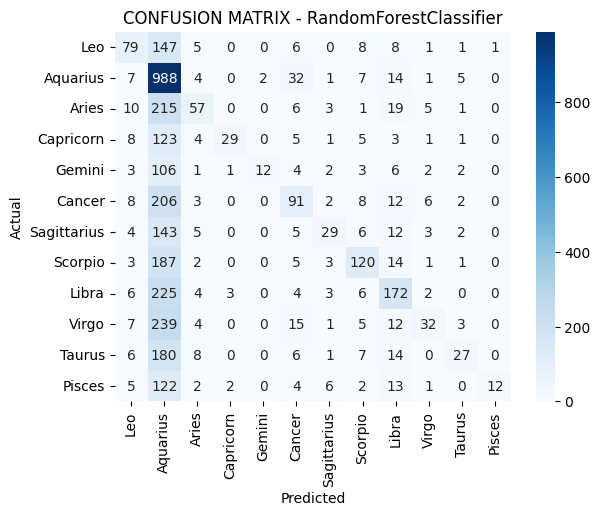

In [34]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d', xticklabels=sign_id_df.sign.values, yticklabels=sign_id_df.sign.values)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("CONFUSION MATRIX - RandomForestClassifier", size=12)

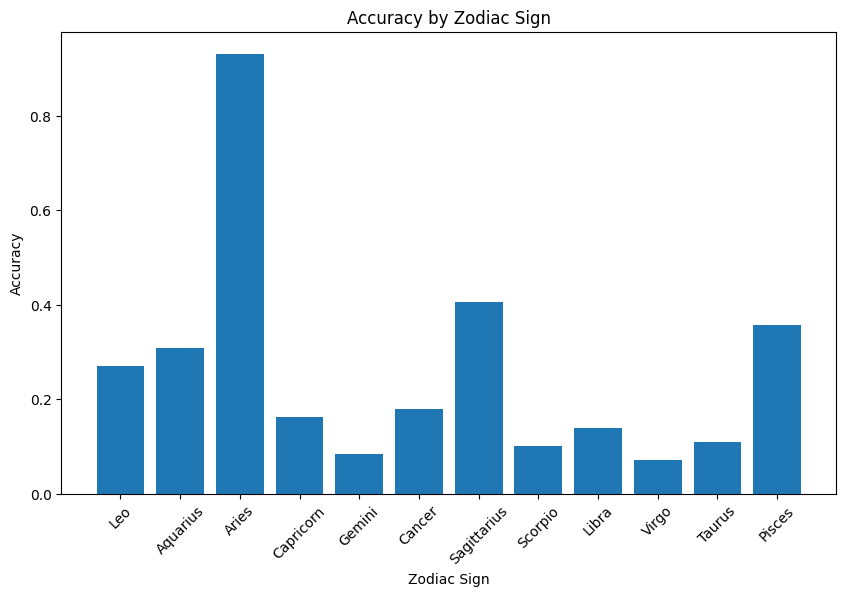

In [35]:
import matplotlib.pyplot as plt

unique_zodiacs = df2["sign"].unique()
accuracy_by_class = [accuracy_score(y_test[y_test == sign], y_pred[y_test == sign]) for sign in unique_zodiacs]

plt.figure(figsize=(10, 6))
plt.bar(unique_zodiacs, accuracy_by_class)
plt.xlabel("Zodiac Sign")
plt.ylabel("Accuracy")
plt.title("Accuracy by Zodiac Sign")
plt.xticks(rotation=45)
plt.show()

# **LinearSVC**


In [36]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [37]:
from sklearn.svm import LinearSVC

# Create and train the LinearSVC model
svc_classifier = LinearSVC()
svc_classifier.fit(X_train, y_train)

LinearSVC()

In [38]:
# Make predictions on the test set
y_pred = svc_classifier.predict(X_test)

In [39]:
from sklearn.metrics import accuracy_score, classification_report

# Calculate accuracy
accuracy_linsvc = accuracy_score(y_test, y_pred)
print("Accuracy for Zodiac Sign Prediction using LinearSVC:", accuracy_linsvc )

Accuracy for Zodiac Sign Prediction using LinearSVC: 0.55275


In [40]:
# Print the classification report
print("\nClassification Report for Zodiac Sign Prediction:")
print(classification_report(y_test, y_pred))


Classification Report for Zodiac Sign Prediction:
              precision    recall  f1-score   support

    Aquarius       0.54      0.52      0.53       256
       Aries       0.56      0.80      0.66      1061
      Cancer       0.51      0.42      0.46       317
   Capricorn       0.64      0.49      0.56       180
      Gemini       0.55      0.25      0.34       142
         Leo       0.42      0.41      0.41       338
       Libra       0.67      0.50      0.57       209
      Pisces       0.63      0.59      0.61       336
 Sagittarius       0.58      0.57      0.58       425
     Scorpio       0.55      0.43      0.48       318
      Taurus       0.47      0.39      0.42       249
       Virgo       0.59      0.35      0.44       169

    accuracy                           0.55      4000
   macro avg       0.56      0.48      0.50      4000
weighted avg       0.55      0.55      0.54      4000



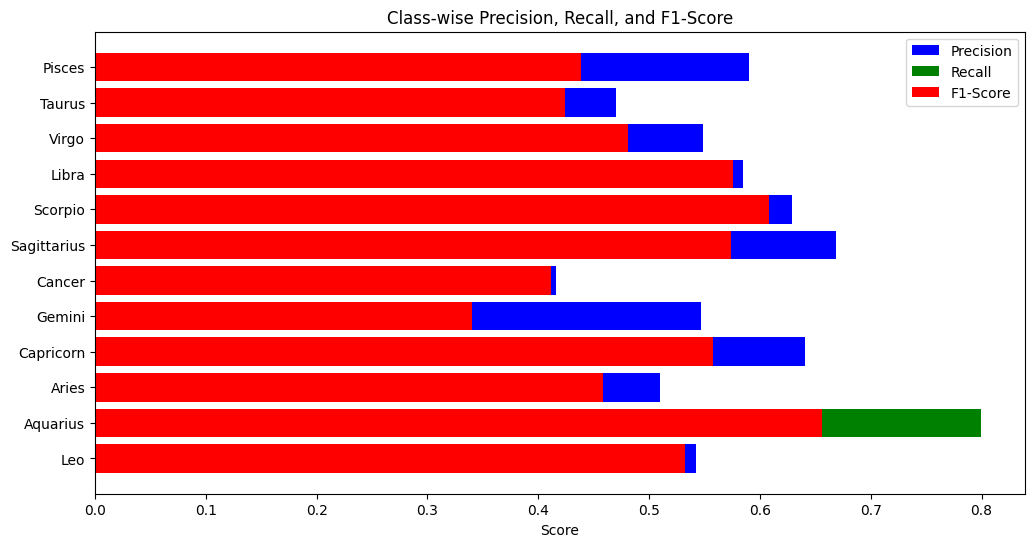

In [41]:
from sklearn.metrics import classification_report

# Get the classification report
report = classification_report(y_test, y_pred, target_names=sign_id_df.sign.values, output_dict=True)

# Extract precision, recall, and F1-score for each class
class_names = list(report.keys())[:-3]  # Exclude 'micro avg', 'macro avg', 'weighted avg'
precision_values = [report[class_name]['precision'] for class_name in class_names]
recall_values = [report[class_name]['recall'] for class_name in class_names]
f1_values = [report[class_name]['f1-score'] for class_name in class_names]

# Plot the class-wise metrics
plt.figure(figsize=(12, 6))
plt.barh(class_names, precision_values, color='b', label='Precision')
plt.barh(class_names, recall_values, color='g', label='Recall')
plt.barh(class_names, f1_values, color='r', label='F1-Score')
plt.xlabel('Score')
plt.title('Class-wise Precision, Recall, and F1-Score')
plt.legend()
plt.show()

Text(0.5, 1.0, 'CONFUSION MATRIX - LinearSVC')

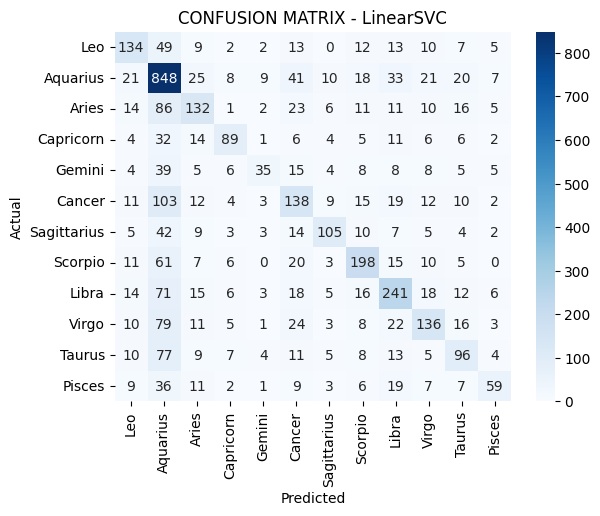

In [42]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d', xticklabels=sign_id_df.sign.values, yticklabels=sign_id_df.sign.values)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("CONFUSION MATRIX - LinearSVC", size=12)

#**LinearSVC Model Tunning**

We can start with Random Search to quickly narrow down the hyperparameter space and then refine our search using Grid Search around the promising regions.

**Random Search**

In [43]:
# Define the parameter distribution to sample from
param_dist = {
    'C': [0.01, 0.1, 1, 10],         # Regularization parameter
    'loss': ['hinge', 'squared_hinge'],  # Loss function
    'max_iter': randint(100, 500)    # Maximum number of iterations
}

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(svc_classifier, param_distributions=param_dist, n_iter=10, cv=5, n_jobs=-1)

# Perform the random search
random_search.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=LinearSVC(), n_jobs=-1,
                   param_distributions={'C': [0.01, 0.1, 1, 10],
                                        'loss': ['hinge', 'squared_hinge'],
                                        'max_iter': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x798b99b87970>})

In [44]:
# Print the best hyperparameters and corresponding accuracy
print("Best Hyperparameters:", random_search.best_params_)
print("Best Accuracy:", random_search.best_score_)

Best Hyperparameters: {'C': 1, 'loss': 'hinge', 'max_iter': 166}
Best Accuracy: 0.54225


**Grid Search**

In [ ]:
# Define the parameter grid to search based on the best hyperparameters from Random Search
param_grid = {
    'C': [0.8, 0.9, 1, 1.1, 1.2],         # Narrower range around the best 'C' value
    'loss': ['hinge'],                    # Use the best 'loss' value
    'max_iter': [300, 350, 400]            # Narrower range around the best 'max_iter' value
}

# Create the GridSearchCV object
grid_search = GridSearchCV(svc_classifier, param_grid, cv=5, n_jobs=-1)

# Perform the grid search
grid_search.fit(X_train, y_train)

In [ ]:
# Print the best hyperparameters and corresponding accuracy
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

**Training LinearSVC using best Hyperparameters**

In [46]:
# Create a LinearSVC model with the best hyperparameters from Grid Search
best_svc_model = LinearSVC(C=1.2, loss='hinge', max_iter=300)

In [47]:
# Train the model on the entire training dataset
best_svc_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = best_svc_model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [48]:
# Calculate accuracy and other metrics
accuracy_tune = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Accuracy:", accuracy_tune)


Accuracy: 0.5625


In [49]:
print("Classification Report:\n", classification_rep)

Classification Report:
               precision    recall  f1-score   support

    Aquarius       0.54      0.54      0.54       256
       Aries       0.57      0.80      0.67      1061
      Cancer       0.49      0.43      0.45       317
   Capricorn       0.66      0.52      0.58       180
      Gemini       0.48      0.26      0.34       142
         Leo       0.46      0.43      0.44       338
       Libra       0.60      0.50      0.55       209
      Pisces       0.64      0.62      0.63       336
 Sagittarius       0.64      0.55      0.59       425
     Scorpio       0.54      0.43      0.48       318
      Taurus       0.47      0.42      0.45       249
       Virgo       0.61      0.38      0.47       169

    accuracy                           0.56      4000
   macro avg       0.56      0.49      0.52      4000
weighted avg       0.56      0.56      0.55      4000



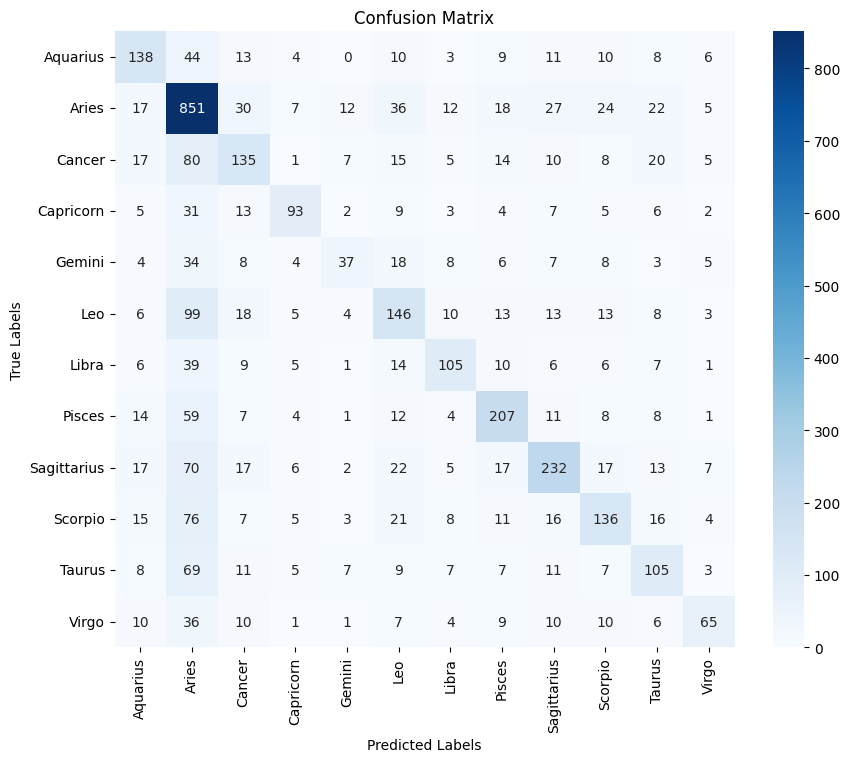

In [50]:
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=best_svc_model.classes_, yticklabels=best_svc_model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

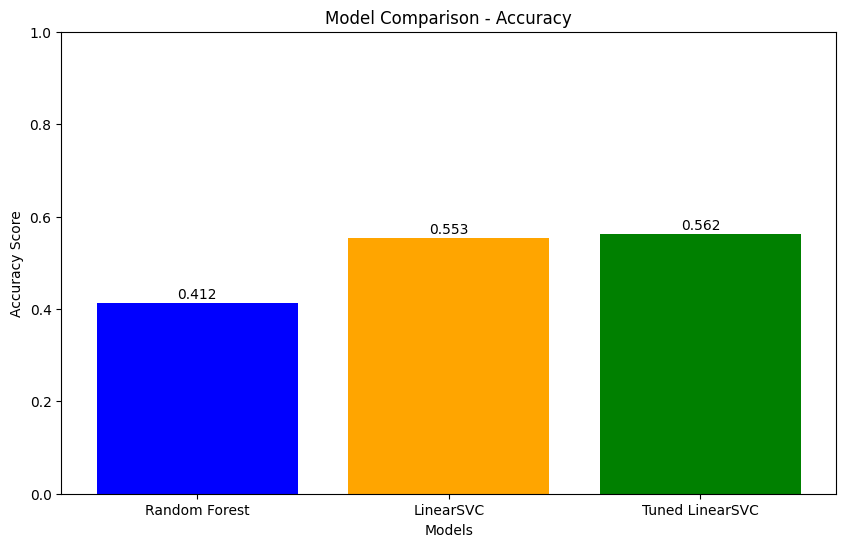

In [51]:
# List of model names
model_names = ['Random Forest', 'LinearSVC', 'Tuned LinearSVC']

# List of pre-calculated accuracy values
accuracies = [accuracy_rf, accuracy_linsvc, accuracy_tune]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color=['blue', 'orange', 'green'])
plt.xlabel('Models')
plt.ylabel('Accuracy Score')
plt.title('Model Comparison - Accuracy')
plt.ylim(0.0, 1.0)  # Set y-axis range

# Adding accuracy values as labels on top of bars
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{accuracy:.3f}', ha='center', color='black')

plt.show()